In [1]:
%reload_ext autoreload
%autoreload 2

In [20]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import textattack
from textattack.models.wrappers import ModelWrapper
from textattack.datasets import HuggingFaceDataset
from textattack.attack_recipes import TextFoolerJin2019, DeepWordBugGao2018, Pruthi2019

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# https://www.gitmemory.com/issue/QData/TextAttack/424/795806095

In [3]:
class CustomModelWrapper(ModelWrapper):
    def __init__(self, model, tokenizer, batch_size=8):
        self.model = model
        self.tokenizer = tokenizer
        self.device = next(self.model.parameters()).device
        self.batch_size = batch_size

    def __call__(self, text_input_list):
        out = []
        i = 0
        while i < len(text_input_list):
            batch = text_input_list[i : i + self.batch_size]
            encoding = self.tokenizer(batch, padding=True, truncation=True, max_length=250, return_tensors='pt')
            outputs = self.model(encoding['input_ids'].to(self.device), attention_mask=encoding['attention_mask'].to(self.device))
            preds = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu()
            out.append(preds)
            i += self.batch_size
        out = torch.cat(out)
        return out

In [4]:
dataset = HuggingFaceDataset("glue", "sst2", "train", shuffle=True)

num_examples = 100

MODEL_NAMES = ['bert-base-uncased', 'roberta-base', 'xlnet-base-cased']
ts = ['ORIG', 'INV', 'SIB', 'INVSIB', 'TextMix', 'SentMix', 'WordMix']
recipes = [TextFoolerJin2019, DeepWordBugGao2018, Pruthi2019]

results = []

for MODEL_NAME in MODEL_NAMES:
    for t in ts: 
        
        checkpoint = 'pretrained/' + MODEL_NAME + "-sst2-ORIG+" + t 
        recent_checkpoint = [name for name in os.listdir(checkpoint) if 'checkpoint' in name]
        if recent_checkpoint:
            checkpoint = os.path.join(checkpoint, recent_checkpoint[0])
        model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        
        print(checkpoint, "initialized...")

        mw = CustomModelWrapper(model, tokenizer)
        
        for recipe in recipes:

            attack = recipe.build(mw)
            attack_results = attack.attack_dataset(dataset, indices=range(num_examples))

            num_results = 0
            num_failures = 0
            num_successes = 0

            for result in attack_results:
                
                # print(result.__str__(color_method='ansi'))
                
                num_results += 1
                if (type(result) == textattack.attack_results.SuccessfulAttackResult or 
                    type(result) == textattack.attack_results.MaximizedAttackResult):
                    num_successes += 1
                if type(result) == textattack.attack_results.FailedAttackResult:
                    num_failures += 1

            attack_success = num_successes / num_results
            results.append({
                'checkpoint': checkpoint,
                'recipe': recipe.__name__,
                'attack_success': attack_success
            })

            print("{0} Attack Success: {1:0.2f}".format(recipe.__name__, attack_success))

Reusing dataset glue (C:\Users\Fabrice\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
textattack: Loading datasets dataset glue, subset sst2, split train.
Using C:\Users\Fabrice\AppData\Local\Temp\tfhub_modules to cache modules.


pretrained/bert-base-uncased-sst2-ORIG+ORIG initialized...


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.91


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.77
Pruthi2019 Attack Success: 0.67
pretrained/bert-base-uncased-sst2-ORIG+INV\checkpoint-8000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.85


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.69
Pruthi2019 Attack Success: 0.55
pretrained/bert-base-uncased-sst2-ORIG+SIB\checkpoint-120000 initialized...


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.89


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.78
Pruthi2019 Attack Success: 0.70
pretrained/bert-base-uncased-sst2-ORIG+INVSIB\checkpoint-28000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.89


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.78
Pruthi2019 Attack Success: 0.57
pretrained/bert-base-uncased-sst2-ORIG+TextMix\checkpoint-58000 initialized...


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.89


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.79
Pruthi2019 Attack Success: 0.65
pretrained/bert-base-uncased-sst2-ORIG+SentMix\checkpoint-14000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.77


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.65
Pruthi2019 Attack Success: 0.56
pretrained/bert-base-uncased-sst2-ORIG+WordMix\checkpoint-128000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.72


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.64


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

Pruthi2019 Attack Success: 0.63
pretrained/roberta-base-sst2-ORIG+ORIG\checkpoint-4000 initialized...


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.78


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.67
Pruthi2019 Attack Success: 0.48
pretrained/roberta-base-sst2-ORIG+INV\checkpoint-4000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.79


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.55


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

Pruthi2019 Attack Success: 0.39
pretrained/roberta-base-sst2-ORIG+SIB\checkpoint-6000 initialized...


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.86


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.76
Pruthi2019 Attack Success: 0.54
pretrained/roberta-base-sst2-ORIG+INVSIB\checkpoint-8000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.82


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.58


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

Pruthi2019 Attack Success: 0.47
pretrained/roberta-base-sst2-ORIG+TextMix\checkpoint-30000 initialized...


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.86


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.72
Pruthi2019 Attack Success: 0.66
pretrained/roberta-base-sst2-ORIG+SentMix\checkpoint-50000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.87


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.77
Pruthi2019 Attack Success: 0.55
pretrained/roberta-base-sst2-ORIG+WordMix\checkpoint-22000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.86


textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.78
Pruthi2019 Attack Success: 0.53
pretrained/xlnet-base-cased-sst2-ORIG+ORIG\checkpoint-4000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.78


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.74


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

Pruthi2019 Attack Success: 0.59
pretrained/xlnet-base-cased-sst2-ORIG+INV\checkpoint-12000 initialized...


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TextFoolerJin2019 Attack Success: 0.86


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.65
Pruthi2019 Attack Success: 0.45
pretrained/xlnet-base-cased-sst2-ORIG+SIB\checkpoint-8000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.78


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.56
Pruthi2019 Attack Success: 0.38
pretrained/xlnet-base-cased-sst2-ORIG+INVSIB\checkpoint-8000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.74


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.61
Pruthi2019 Attack Success: 0.41
pretrained/xlnet-base-cased-sst2-ORIG+TextMix\checkpoint-14000 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.87


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.79
Pruthi2019 Attack Success: 0.65
pretrained/xlnet-base-cased-sst2-ORIG+SentMix\checkpoint-12500 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.86


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.75
Pruthi2019 Attack Success: 0.57
pretrained/xlnet-base-cased-sst2-ORIG+WordMix\checkpoint-24500 initialized...


Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x000002AA1D108550>
Traceback (most recent call last):
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py", line 208, in __del__
    self._destroy_resource()
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 725, in _initialize
    self._stateful_fn._get_concrete_function_internal_garbage_collected(  # pylint: disable=protected-access
  Fil

TextFoolerJin2019 Attack Success: 0.85


textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


DeepWordBugGao2018 Attack Success: 0.76
Pruthi2019 Attack Success: 0.57


In [11]:
df = pd.DataFrame(results)
df.to_csv('adv_attack_sst2.csv')

,checkpoint,recipe,attack_success
0,pretrained/bert-base-uncased-sst2-ORIG+ORIG,TextFoolerJin2019,0.91
1,pretrained/bert-base-uncased-sst2-ORIG+ORIG,DeepWordBugGao2018,0.77
2,pretrained/bert-base-uncased-sst2-ORIG+ORIG,Pruthi2019,0.67
3,pretrained/bert-base-uncased-sst2-ORIG+INV\che...,TextFoolerJin2019,0.85
4,pretrained/bert-base-uncased-sst2-ORIG+INV\che...,DeepWordBugGao2018,0.69
...,...,...,...
58,pretrained/xlnet-base-cased-sst2-ORIG+SentMix\...,DeepWordBugGao2018,0.75
59,pretrained/xlnet-base-cased-sst2-ORIG+SentMix\...,Pruthi2019,0.57
60,pretrained/xlnet-base-cased-sst2-ORIG+WordMix\...,TextFoolerJin2019,0.85
61,pretrained/xlnet-base-cased-sst2-ORIG+WordMix\...,DeepWordBugGao2018,0.76


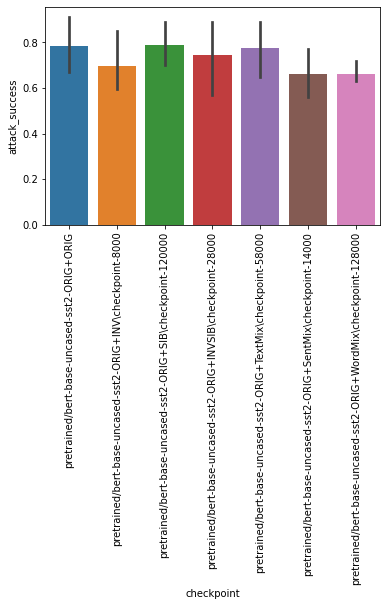

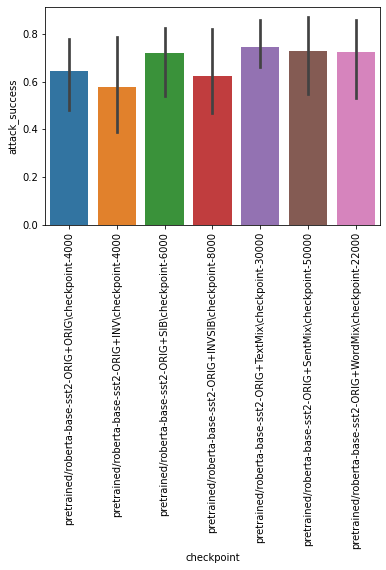

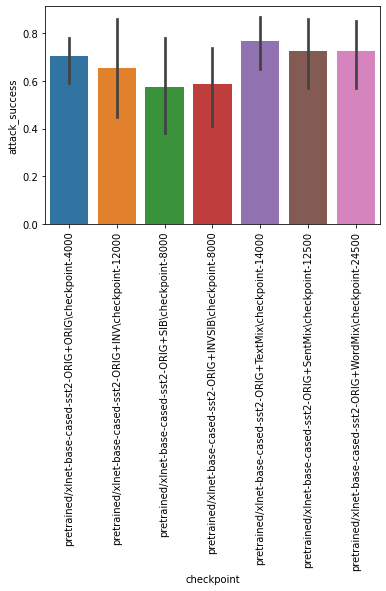

In [22]:
for MODEL_NAME in MODEL_NAMES:
    idx = df['checkpoint'].str.contains(MODEL_NAME)
    g = sns.barplot(data=df[idx], x="checkpoint", y="attack_success")
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.show()

In [5]:
dataset = HuggingFaceDataset("ag_news", None, "test", shuffle=True)

num_examples = 100

MODEL_NAMES = ['bert-base-uncased', 'roberta-base', 'xlnet-base-cased']
ts = ['ORIG', 'INV', 'SIB', 'INVSIB', 'TextMix', 'SentMix', 'WordMix']
recipes = [TextFoolerJin2019, DeepWordBugGao2018, Pruthi2019]

results = []

for MODEL_NAME in MODEL_NAMES:
    for t in ts: 
        
        checkpoint = 'pretrained/' + MODEL_NAME + "-ag_news-ORIG+" + t 
        recent_checkpoint = [name for name in os.listdir(checkpoint) if 'checkpoint' in name]
        if recent_checkpoint:
            checkpoint = os.path.join(checkpoint, recent_checkpoint[0])
        model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4).to(device)
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        
        print(checkpoint, "initialized...")

        mw = CustomModelWrapper(model, tokenizer)
        
        for recipe in recipes:

            attack = recipe.build(mw)
            attack_results = attack.attack_dataset(dataset, indices=range(num_examples))

            num_results = 0
            num_failures = 0
            num_successes = 0

            for result in attack_results:
                
                # print(result.__str__(color_method='ansi'))
                
                num_results += 1
                if (type(result) == textattack.attack_results.SuccessfulAttackResult or 
                    type(result) == textattack.attack_results.MaximizedAttackResult):
                    num_successes += 1
                if type(result) == textattack.attack_results.FailedAttackResult:
                    num_failures += 1

            attack_success = num_successes / num_results
            results.append({
                'checkpoint': checkpoint,
                'recipe': recipe.__name__,
                'attack_success': attack_success
            })

            print("{0} Attack Success: {1:0.2f}".format(recipe.__name__, attack_success))

In [ ]:
df = pd.DataFrame(results)
df.to_csv('adv_attack_ag_news.csv')

In [ ]:
for MODEL_NAME in MODEL_NAMES:
    idx = df['checkpoint'].str.contains(MODEL_NAME)
    g = sns.barplot(data=df[idx], x="checkpoint", y="attack_success")
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.show()